In [1]:
from one.api import ONE
import numpy as np
import matplotlib.pyplot as plt

#!pip install umap-learn==0.5.3
from umap import umap_ as umap

#!pip install networkx==2.4
import networkx as nx

#!pip install python-igraph
import igraph as ig

one = ONE(base_url='https://openalyx.internationalbrainlab.org', password='international')
# specify experiment ID
eid = '19e66dc9-bf9f-430b-9d6a-acfa85de6fb7'

/home/maria/anaconda3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/maria/anaconda3/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/maria/anaconda3/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWarning:

In [42]:
def get_waveforms(eid):
    #Waveforms has shape (nr_units, nr_timepoints, 32_top_waveforms_channel (out of ca 300))
    waveforms = one.load_dataset(eid, 'clusters.waveforms')
    #print(waveforms.shape)
    waveform_channels = one.load_dataset(eid, 'clusters.waveformsChannels')
    channels=one.load_dataset(eid, 'clusters.channels.npy')
    #print(waveform_channels.shape)
    unnormWFs=[]

    for i, waveform_channel in enumerate(waveform_channels):
        index = np.where(np.squeeze(waveform_channel)==channels[i])[0]
        cluster_waveform = waveforms[i, :,index].squeeze()
        unnormWFs.append(cluster_waveform)
        
    return np.array(unnormWFs)

def fit_model(unnormWFs):
    import sklearn.preprocessing
    normWFs = sklearn.preprocessing.normalize(unnormWFs,norm = 'max')
    from umap import umap_ as umap
    reducer = umap.UMAP(random_state=42, n_neighbors=20, min_dist=0.1,metric='euclidean')
    mapper = reducer.fit(normWFs)
    from networkx import convert_matrix 
    G = convert_matrix.from_scipy_sparse_array(mapper.graph_)
    clustering = nx.community.louvain_partitions(G, seed=123,resolution=1.5)
    cl=next(clustering)
    
    clustering_solution=[]

    for i in range(0,normWFs.shape[0]):
        ind=0
        for j in cl:
            if i in j:
                clustering_solution.append(ind)
            ind+=1
    import pandas as pd
    from matplotlib import cm
    from matplotlib import pyplot as plt
    import seaborn as sns
    import colorcet as cc

    embedding = reducer.fit_transform(normWFs)
    umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
    umap_df['waveform'] = list(normWFs)
    umap_df['cluster_id'] = clustering_solution
    cmap = plt.get_cmap("CMRmap")
    palette = sns.color_palette(cc.glasbey, n_colors=len(set(clustering_solution)))
    colors = cmap(np.linspace(0, 1, len(set(clustering_solution))))
    umap_df['cluster_color'] = [palette[i] for i in clustering_solution]
    
    print(len(set(clustering_solution)))
    
    #from sklearn.manifold import TSNE

    #X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=60).fit_transform(normWFs)
    #plt.scatter(X_embedded[:,0], X_embedded[:,1], marker='o', s=5,c=umap_df['cluster_color'].tolist())
    return umap_df

def add_columns(eid,umap_df):
    channels=channels=one.load_dataset(eid, 'clusters.channels.npy')
    print(channels.shape)
    umap_df['channel_inds']=channels
    brain_loc = one.load_dataset(eid, '*channels.brainLocationIds_ccf_2017.npy')
    brain_areas=[]
    for i, ci in umap_df.iterrows():
        brain_area=brain_loc[ci['channel_inds']]
        brain_areas.append(brain_area)
    umap_df['brain_areas']=brain_areas
    return umap_df
    

In [35]:
unnormWFs=get_waveforms(eid)
umap_df=fit_model(unnormWFs)
#umap_df=add_columns(eid,umap_df)

68


In [43]:
umap_df=add_columns(eid,umap_df)

(795,)


In [44]:
g=umap_df.groupby('brain_areas')
g.size()

brain_areas
155          198
463           77
466            1
577            8
603            4
625           98
733           42
854            7
945           63
997            1
1020         289
1026           2
484682512      1
484682516      4
dtype: int64

In [46]:
g.get_group(1020).groupby('cluster_id').size()

cluster_id
1      2
2      1
3      3
4      7
5      7
6      7
7     11
8      9
9     10
10     5
11     3
12    13
13     1
14     3
15     3
16     4
17    20
18     4
19     6
20     4
21     7
22     6
23    11
24     7
26     2
27     6
28    11
29     3
30     7
31     2
32     5
33     3
34     6
35     5
37     2
38     3
40     5
41     6
42     3
44     4
45     1
46     1
47     2
49     2
52     4
53     3
54    12
55     2
56     4
58     2
59     2
60     1
61     1
62     4
63     3
64     6
65    10
66     1
67     1
dtype: int64

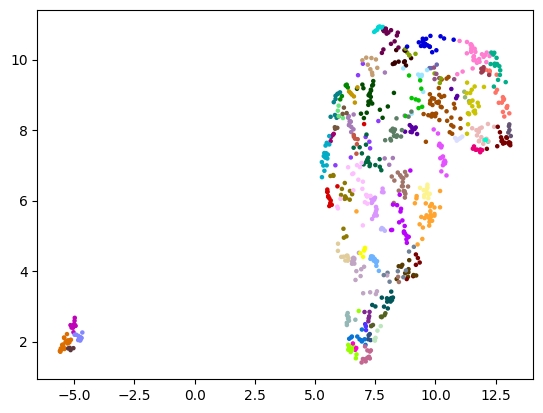

In [31]:
plt.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(), marker='o', s=5,c=umap_df['cluster_color'].tolist())

In [26]:
print(unnormWFs.shape)

(795, 82)


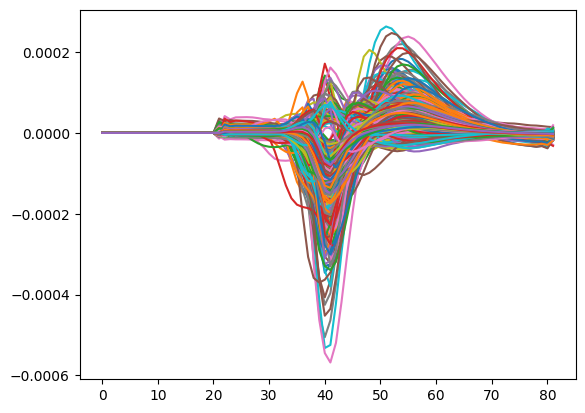

In [28]:
plt.plot(unnormWFs.T)

In [14]:
one.load_dataset(eid,'alf/probe00/pykilosort/clusters.metrics.pqt')

,cluster_id,amp_max,amp_min,amp_median,amp_std_dB,contamination,contamination_alt,drift,missed_spikes_est,noise_cutoff,presence_ratio,presence_ratio_std,slidingRP_viol,spike_count,firing_rate,label
0,0,0.000245,0.000097,0.000106,0.934220,0.066170,0.058348,290691.811630,0.500000,578.273003,0.998028,22.373874,1.0,30018.0,5.933501,0.666667
1,1,0.000253,0.000083,0.000105,1.352128,0.025192,0.023277,829429.686667,0.500000,264.563497,0.996055,95.130797,1.0,73344.0,14.497526,0.666667
2,2,0.000202,0.000092,0.000109,1.171765,0.091406,0.079038,46043.149895,0.500000,28.051865,0.972387,5.525626,0.0,4446.0,0.878818,0.333333
3,3,0.000218,0.000083,0.000105,1.235853,0.161737,0.133205,198574.308153,0.232151,83.938577,0.998028,8.502331,0.0,15677.0,3.098791,0.333333
4,4,0.000122,0.000078,0.000084,0.967765,0.000000,0.000000,1362.015579,NaN,17.214745,0.163708,0.477643,0.0,99.0,0.019569,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,790,0.000143,0.000104,0.000111,0.587864,0.000000,0.000000,312.806786,NaN,1.414214,0.035503,0.309822,0.0,26.0,0.005139,0.666667
791,791,0.000235,0.000166,0.000181,0.704828,0.000000,0.000000,679.012338,NaN,6.225302,0.173570,0.456530,0.0,99.0,0.019569,0.333333
792,792,0.000138,0.000069,0.000090,1.033415,0.000000,0.000000,1203.078118,NaN,1.211200,0.276134,1.277251,0.0,307.0,0.060683,0.666667
793,793,0.000158,0.000076,0.000106,1.166509,0.000000,0.000000,2272.938549,0.066457,0.774101,0.333333,2.356354,0.0,557.0,0.110099,0.666667


In [2]:
one.list_datasets(eid)

['alf/_ibl_trials.goCueTrigger_times.npy',
 'alf/_ibl_trials.stimOff_times.npy',
 'alf/_ibl_trials.table.pqt',
 'alf/_ibl_wheel.position.npy',
 'alf/_ibl_wheel.timestamps.npy',
 'alf/_ibl_wheelMoves.intervals.npy',
 'alf/_ibl_wheelMoves.peakAmplitude.npy',
 'alf/probe00/electrodeSites.brainLocationIds_ccf_2017.npy',
 'alf/probe00/electrodeSites.localCoordinates.npy',
 'alf/probe00/electrodeSites.mlapdv.npy',
 'alf/probe00/pykilosort/_ibl_log.info_pykilosort.log',
 'alf/probe00/pykilosort/_kilosort_whitening.matrix.npy',
 'alf/probe00/pykilosort/_phy_spikes_subset.channels.npy',
 'alf/probe00/pykilosort/_phy_spikes_subset.spikes.npy',
 'alf/probe00/pykilosort/_phy_spikes_subset.waveforms.npy',
 'alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy',
 'alf/probe00/pykilosort/channels.localCoordinates.npy',
 'alf/probe00/pykilosort/channels.mlapdv.npy',
 'alf/probe00/pykilosort/channels.rawInd.npy',
 'alf/probe00/pykilosort/clusters.amps.npy',
 'alf/probe00/pykilosort/clusters.ch

In [49]:
import pandas as pd
from brainbox.task import trials
from one.api import ONE
def get_raster_and_psth(eid):
    #Load trials into df
    dat = one.load_dataset(eid, 'alf/_ibl_trials.table.pqt')
    df=pd.DataFrame(dat)
    #Choose one type of event
    trials_=df.loc[(df['choice'] == 1) & (df['contrastLeft'] == 1.0)].index
    #df=df.loc[(df['choice'] == 1) & (df['contrastLeft'] == 1.0)]
    events=df["stimOn_times"]
    #Get spike_times
    spike_times=one.load_dataset(eid, 'alf/probe00/pykilosort/spikes.times.npy')
    #Get clusters
    spike_clusters=one.load_dataset(eid, 'alf/probe00/pykilosort/spikes.clusters.npy')
    print(len(spike_clusters))
    print(spike_times.shape)
    #Get binned rasters
    raster_dict={}
    time_vec={}
    for n in list(np.unique(spike_clusters)):
        neuron=np.where(spike_clusters==n)
        if len(list(neuron[0]))!=0:
            #print(len(list(neuron[0])))
            raster=trials.get_event_aligned_raster(spike_times[neuron], events, tbin=0.1, values=None, epoch=[-0.5, 2], bin=True)
            #print(raster)
            if np.isnan(raster[0]).any()==False:
                raster_dict[n]=raster[0]
        time_vec=raster[1]
    psth_dict={}
    for k in raster_dict.keys():
        psth=trials.get_psth(raster_dict[k],trial_ids=trials_)
        psth_dict[k]=psth
    return raster_dict,psth_dict,time_vec

raster_dict, psth_dict,time_vec=get_raster_and_psth(eid)

20177238
(20177238,)


In [52]:
umap_df.groupby('cluster_id').size()

cluster_id
0     12
1      8
2      6
3     17
4     12
      ..
63     9
64    16
65    19
66     5
67     4
Length: 68, dtype: int64

In [53]:
umap_df.head()

,x,y,waveform,cluster_id,cluster_color,channel_inds,brain_areas
0,9.362836,9.496089,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",25,"(0.6039215686274509, 0.8941176470588236, 1.0)",0,733
1,6.598262,8.022847,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",27,"(0.6470588235294118, 0.4823529411764706, 0.721...",0,733
2,10.249271,8.937407,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",30,"(0.6196078431372549, 0.29411764705882354, 0.0)",0,733
3,5.365006,7.262664,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,"(0.0, 0.6745098039215687, 0.7764705882352941)",1,733
4,5.519072,6.251277,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"(0.8392156862745098, 0.0, 0.0)",0,733


In [85]:
np.argsort(umap_df.groupby('cluster_id').size())

cluster_id
0     61
1     53
2     51
3     11
4     14
      ..
63    20
64    40
65     5
66     7
67    30
Length: 68, dtype: int64

In [88]:
umap_df[(umap_df['cluster_id']==30)]

,x,y,waveform,cluster_id,cluster_color,channel_inds,brain_areas
2,10.249271,8.937407,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",30,"(0.6196078431372549, 0.29411764705882354, 0.0)",0,733
10,10.167068,8.284447,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",30,"(0.6196078431372549, 0.29411764705882354, 0.0)",2,733
11,10.666617,8.355712,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",30,"(0.6196078431372549, 0.29411764705882354, 0.0)",2,733
16,9.835390,8.386315,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",30,"(0.6196078431372549, 0.29411764705882354, 0.0)",6,733
23,10.029121,8.470126,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",30,"(0.6196078431372549, 0.29411764705882354, 0.0)",10,733
69,10.262613,8.647619,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",30,"(0.6196078431372549, 0.29411764705882354, 0.0)",37,1020
88,10.660440,8.141639,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",30,"(0.6196078431372549, 0.29411764705882354, 0.0)",45,1020
98,9.945937,8.890635,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",30,"(0.6196078431372549, 0.29411764705882354, 0.0)",48,1020
168,9.860698,8.908605,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",30,"(0.6196078431372549, 0.29411764705882354, 0.0)",70,1020
270,10.125640,8.768150,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",30,"(0.6196078431372549, 0.29411764705882354, 0.0)",106,1020


In [92]:
cl=[]
for key in psth_dict.keys():
    if key in umap_df[(umap_df['cluster_id']==7)].index:
        cl.append(psth_dict[key][0])
        #print(psth_dict[key])

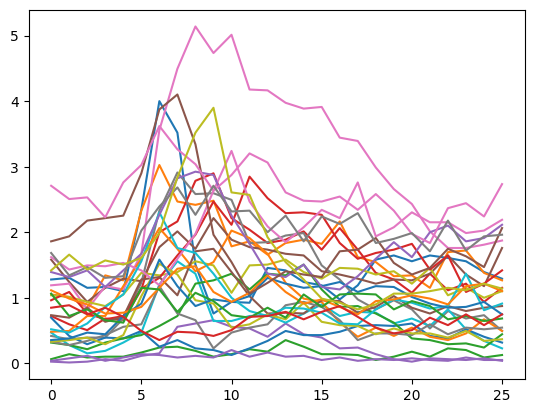

In [93]:
cl=np.array(cl)

plt.plot(cl.T)

In [79]:
cl

array([], dtype=float64)